In [7]:
# importing libraries
import pandas            as pd                       # data science essentials
import numpy as np
import matplotlib.pyplot as plt                      # data visualization
import seaborn           as sns                      # enhanced data viz
from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import plot_tree                   # tree plots
from sklearn.model_selection import RandomizedSearchCV  # tuning
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier # trees
from sklearn.ensemble import GradientBoostingClassifier # GBM


# loading data
data = './__storage/GOT_character_predictions.xlsx'
got = pd.read_excel(io = data)


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# displaying the head of the dataset
got.head(n = 5)
#got.info()

,S.No,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,book1_A_Game_Of_Thrones,book2_A_Clash_Of_Kings,book3_A_Storm_Of_Swords,book4_A_Feast_For_Crows,book5_A_Dance_with_Dragons,isAliveFather,isAliveMother,isAliveSpouse,isAliveHeir,age,popularity,isAlive
0,1,Erreg,King,0,Andal,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.016722,1
1,2,Hugor of the Hill,King of the Andals,1,Andals,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,0.050167,1
2,3,Azor Ahai,NaN,0,Asshai,NaN,NaN,NaN,NaN,NaN,Nissa Nissa,0,1,1,1,1,NaN,NaN,NaN,1.0,NaN,0.117057,1
3,4,Melisandre,NaN,0,Asshai,NaN,NaN,NaN,NaN,R'hllor,NaN,0,1,1,1,1,NaN,NaN,NaN,NaN,NaN,0.745819,1
4,5,Kraznys mo Nakloz,NaN,1,Astapor,NaN,NaN,NaN,NaN,Good Masters,NaN,0,0,1,0,1,NaN,NaN,NaN,NaN,64.0,0.076923,0


In [8]:
# Addressing missing variables with code from script 6
# user-defined functions

#########################
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df



#########################
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))
        
        
        
########################################
# plot_feature_importances, script 9
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('./analysis_images/Feature_Importance.png')

        

In [9]:
# Using provided UDFs
mv_flagger(got)
text_split_feature('name', got)

# filling empty values
got["age"].fillna(got["age"].mean(), inplace=True) # using mean age 
got.fillna(value=-1, inplace=True) # unkown NaN values to -1

In [10]:
# Stratifying dataset to ascertain who remained alive (1) and died (0)
got.loc[ : ,'isAlive'].value_counts(normalize = True).round(decimals = 2)

1    0.73
0    0.27
Name: isAlive, dtype: float64

In [11]:
# declaring explanatory variables and some vars dropped for lack of relevance
got_data = got.drop(['isAlive', 'title',  'spouse', 'S.No', 'culture', 'dateOfBirth',
                     'name', 'father', 'name', 'mother', 'house', 'heir'], axis = 1)

# declaring response/target variable
got_target = got.loc[ : , 'isAlive']

In [12]:
# Scaling lines 

# INSTANTIATING StandardScaler()
scaler = StandardScaler()

# FITTING the data
scaler.fit(got_data)

# TRANSFORMING the data
got_scaled     = scaler.transform(got_data)

# converting to a DataFrame
got_scaled_df  = pd.DataFrame(got_scaled)

In [24]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            got_data,
            got_target,
            test_size    = 0.10,
            random_state = 219,
            stratify     = got_target) # preserving balance


# merging training data for statsmodels
got_train = pd.concat([x_train, y_train], axis = 1)

In [25]:
# confirming split sets maintaine proportions
print(f"""

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}



Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")




Response Variable Proportions (Training Set)
--------------------------------------------
1    0.73
0    0.27
Name: isAlive, dtype: float64



Response Variable Proportions (Testing Set)
--------------------------------------------
1    0.73
0    0.27
Name: isAlive, dtype: float64



<b> Random Forest <b>

In [26]:
# building a model based on hyperparameter tuning results

# INSTANTIATING Random forest model with best_estimator
forest_tuned = RandomForestClassifier(criterion        = 'gini',
                                      min_samples_leaf = 1,
                                      max_depth        = 8,
                                      n_estimators     = 100,
                                      warm_start       = True,
                                      bootstrap        = True,
                                      random_state     = 219)


# FITTING to the FULL DATASET (due to cross-validation)
forest_tuned_fit = forest_tuned.fit(got_data, got_target)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy
forest_train_test_gap = (abs(forest_tuned_train_score - forest_tuned_test_score).round(4))

# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned Train-Test Gap   :', (abs(forest_tuned_train_score - forest_tuned_test_score).round(4)))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

Forest Tuned Training ACCURACY: 0.8493
Forest Tuned Testing  ACCURACY: 0.8641
Forest Tuned Train-Test Gap   : 0.0148
Forest Tuned AUC Score        : 0.75



True Negatives : 25
False Positives: 25
False Negatives: 0
True Positives : 134



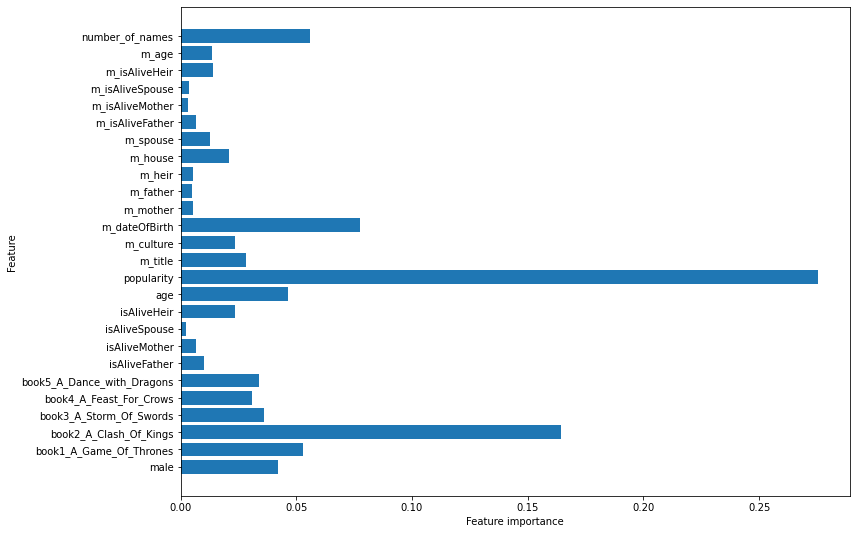

In [16]:
# plotting feature importances
plot_feature_importances(forest_tuned_fit,
                         train = x_train,
                         export = False)

# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")

<b>Classification Trees (CART)<b>
  

In [17]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training ACCURACY: 0.9824
Full Tree Testing ACCURACY : 0.75
Full Tree AUC Score: 0.7155


In [18]:
# building a model based on hyperparameter tuning results, script 8

# INSTANTIATING a decision tree model with tuned values
tree_tuned = DecisionTreeClassifier(splitter         = 'best',
                                    min_samples_leaf = 66,
                                    max_depth        = 8,
                                    criterion        = 'gini',
                                    random_state     = 219)


# FITTING to the FULL DATASET (due to cross-validation)
tree_tuned_fit = tree_tuned.fit(got_data, got_target)


# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy
tree_tuned_train_test_gap = (abs(tree_tuned_train_score-tree_tuned_test_score).round(4))


# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('Train-Test Gap   :', (abs(tree_tuned_train_score-tree_tuned_test_score).round(4)))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_tuned_pred).round(4))



# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                       y_score = tree_tuned_pred).round(4) # auc

Training ACCURACY: 0.7875
Testing  ACCURACY: 0.7989
Train-Test Gap   : 0.0114
AUC Score        : 0.6801



True Negatives : 21
False Positives: 29
False Negatives: 8
True Positives : 126



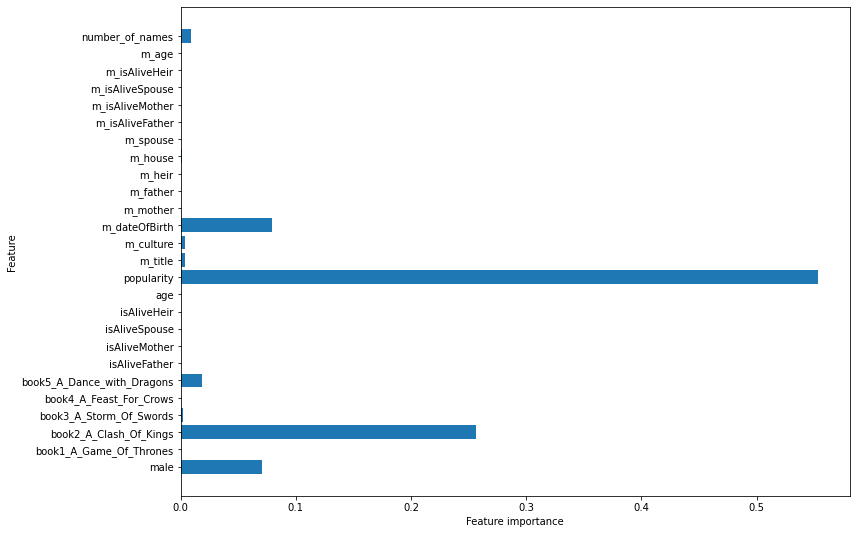

In [19]:
# plotting feature importances
plot_feature_importances(tree_tuned_fit,
                         train = x_train,
                         export = False)

# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")

<b>Logistic Regression<b>

In [20]:
#Create
lr = LogisticRegression()


#Fitting
lr_fit = lr.fit(x_train, y_train)


#Predict
lr_pred = lr_fit.predict(x_test)


# SCORING the results
print('Training Score :', lr.score(x_train, y_train).round(4))  # using R-square
print('Testing Score  :',  lr.score(x_test, y_test).round(4)) # using R-square


lr_train_score = lr.score(x_train, y_train).round(4)
lr_test_score = lr.score(x_test, y_test).round(4)

print('AUC Score          :', roc_auc_score(y_true = y_test,
                    y_score = lr_pred).round(decimals = 4))


#Save
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = lr_pred).round(decimals = 4)

Training Score : 0.7682
Testing Score  : 0.7826
AUC Score          : 0.6376


C:\Users\sejzi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# building a model based on hyperparameter tuning results
# INSTANTIATING a logistic regression model with tuned values
lr_tuned = LogisticRegression(C            = 2.5000000000000004,
                              warm_start   = True,
                              solver       = 'lbfgs',
                              max_iter     = 1000,
                              random_state = 219)


# FITTING the model
lr_tuned.fit=lr_tuned.fit(got_data, got_target)


# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('Train-Test Gap   :', (abs(lr_tuned.score(x_train, y_train)-lr_tuned.score(x_test, y_test)).round(4)))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy
lr_tuned_test_training_gap = (abs(lr_tuned.score(x_train, y_train)-lr_tuned.score(x_test, y_test)).round(4))


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

Training ACCURACY: 0.7809
Testing  ACCURACY: 0.8043
Train-Test Gap   : 0.0235
AUC Score        : 0.6713



True Negatives : 19
False Positives: 31
False Negatives: 5
True Positives : 129



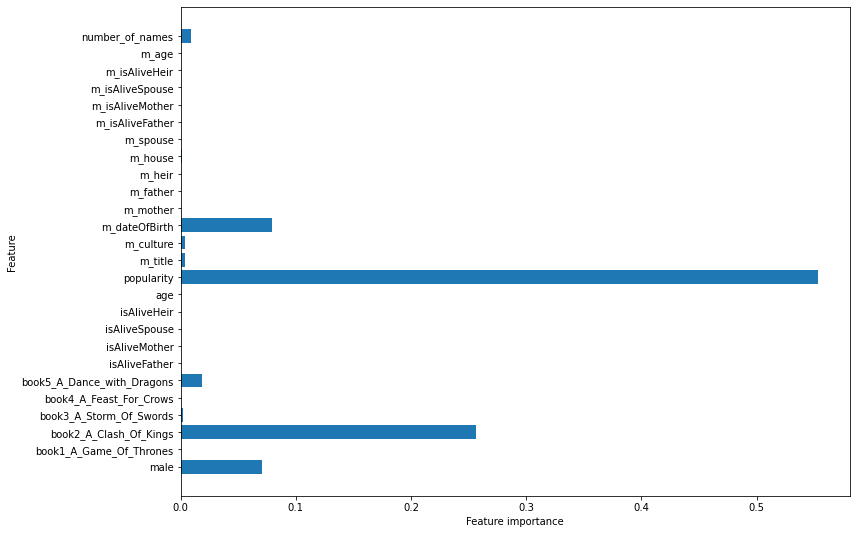

In [22]:
# Confusion Matrix 

# plotting feature importances
plot_feature_importances(tree_tuned_fit,
                         train = x_train,
                         export = False)

# unpacking the confusion matrix
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")

<b>COMPARING RESULTS<b>

In [23]:
# comparing results

print(f"""
Model         Train Score     Test Score  Train-Test Gap    AUC     TN, FP, FN, TP
-----         --------------  ----------  --------------   -----    ---------------
Random Forest*   {forest_tuned_train_score}          {forest_tuned_test_score}       {forest_train_test_gap}           {forest_tuned_auc}   {tuned_rf_tn, tuned_rf_fp, tuned_rf_fn, tuned_rf_tp}    
CART Model      {tree_tuned_train_score}          {tree_tuned_test_score}       {tree_tuned_train_test_gap}           {tree_tuned_auc}   {tuned_tree_tn, tuned_tree_fp, tuned_tree_fn, tuned_tree_tp}
Log Reg         {lr_tuned_train_score}          {lr_tuned_test_score}       {lr_tuned_test_training_gap}           {lr_tuned_auc}   {lr_tuned_tn, lr_tuned_fp, lr_tuned_fn, lr_tuned_tp}


Analysis: The best model to use is Random Forest and I observed that characters live because of their popularity.
""")


Model         Train Score     Test Score  Train-Test Gap    AUC     TN, FP, FN, TP
-----         --------------  ----------  --------------   -----    ---------------
Random Forest*   0.8493          0.8641       0.0148           0.75   (25, 25, 0, 134)    
CART Model      0.7875          0.7989       0.0114           0.6801   (21, 29, 8, 126)
Log Reg         0.7809          0.8043       0.0235           0.6713   (19, 31, 5, 129)


Analysis: The best model to use is Random Forest and I observed that characters live because of their popularity.

